# Saving logits of original and adversarially attacked inputs

The "hack" below allows absolute path imports as if the notebook was a py-file run with `python -m abs.path.to.file.filename`

In [1]:
import sys
root_dir = !cd .. &&pwd
root_dir = root_dir[0] + "/"
sys.path.insert(0, root_dir)

In [2]:
print(root_dir)

/Users/gunder/Desktop/bachelor_project/


### Imports

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from models.classifier32 import classifier32

from our_modules.tin_tools import get_avg_osr_auroc_across_splits
from our_modules.tin_tools import transform_range as tin_clip_range

from our_modules.adv_tools import fp_osr_fgsm, fn_osr_fgsm, fp_osr_fgsm_sum_exp



### Setting the Device

In [4]:
if sys.platform == 'darwin':
    device = torch.device("mps")
else:
    gpu = torch.cuda.is_available()
    device = torch.device("cuda:0" if gpu else "cpu")

print("device:", device)

device: mps


## tiny-imagenet

In [5]:
path_to_pretrained_weights_folder = root_dir + "pretrained_weights/"
tin_val_root_dir = root_dir + "datasets/tiny-imagenet-200/val/images/"
tin_logits_dir = root_dir + "logits/tinyimagenet/"

### Saving plain logits

In [6]:
#get_avg_osr_auroc_across_splits(path_to_pretrained_weights_folder, tin_val_root_dir, device, logdir=tin_logits_dir + "plain/")

### Savining Advesarial Attacks Logits

#### FGSM for different epsilon

##### FN

In [7]:
def fgsm_eps_experiment(eps_list, fgsm, logdir, number_of_splits=5, **fgsm_kwargs):
    for eps in eps_list:
        attack = (lambda x, y, model: fgsm(model, x, eps=eps, clip_range=tin_clip_range, **fgsm_kwargs))
        get_avg_osr_auroc_across_splits(path_to_pretrained_weights_folder, tin_val_root_dir, device, logdir + f"eps_{eps:.3}/", adv_attack=attack, number_of_splits=number_of_splits)


In [12]:
eps = np.logspace(np.log10(0.0001),np.log10(1), 25)

In [13]:
eps

array([1.00000000e-04, 1.46779927e-04, 2.15443469e-04, 3.16227766e-04,
       4.64158883e-04, 6.81292069e-04, 1.00000000e-03, 1.46779927e-03,
       2.15443469e-03, 3.16227766e-03, 4.64158883e-03, 6.81292069e-03,
       1.00000000e-02, 1.46779927e-02, 2.15443469e-02, 3.16227766e-02,
       4.64158883e-02, 6.81292069e-02, 1.00000000e-01, 1.46779927e-01,
       2.15443469e-01, 3.16227766e-01, 4.64158883e-01, 6.81292069e-01,
       1.00000000e+00])

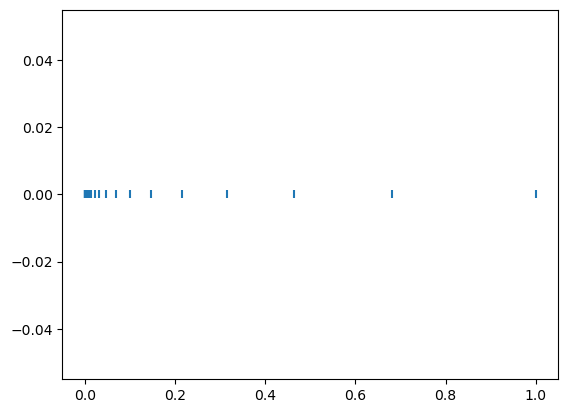

In [14]:
fig, ax = plt.subplots(1,1)
ax.scatter(eps, np.zeros_like(eps), marker ='|')
plt.show()

In [15]:
#fgsm_eps_experiment(eps, fn_osr_fgsm, tin_logits_dir + "fn/fgsm/", 1)

#### FP

2-norm

In [16]:
#fgsm_eps_experiment(eps_list=eps, fgsm=fp_osr_fgsm, logdir=tin_logits_dir + "fp/fgsm/two_norm/", number_of_splits=1, norm_ord=None)
#fgsm_eps_experiment(eps_list=eps, fgsm=fp_osr_fgsm, logdir=tin_logits_dir + "fp/fgsm/inf_norm/", number_of_splits=1, norm_ord=torch.inf)
fgsm_eps_experiment(eps_list=eps, fgsm=fp_osr_fgsm_sum_exp, logdir=tin_logits_dir + "fp/fgsm/sum_exp/", number_of_splits=1)

100%|██████████| 1/1 [01:30<00:00, 90.25s/it]


In [8]:
#get_avg_osr_auroc_across_splits(path_to_pretrained_weights_folder, tin_val_root_dir, device, logdir=root_dir + "logits/tinyimagenet/", adv_attack=fgsm_fp_attack, adv_attack_name='fgsm_fp_attack')
# get_avg_osr_auroc_across_splits(path_to_pretrained_weights_folder, tin_val_root_dir, device, logdir=root_dir + "logits/tinyimagenet/", adv_attack=fgsm_fn_attack, adv_attack_name='fgsm_fn_attack')

  0%|          | 0/5 [00:00<?, ?it/s]/Users/gunder/Desktop/bachelor_project/our_modules/adv_tools.py:25: UserWarning: The operator 'aten::linalg_vector_norm' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  return fgsm(model, x, torch.zeros(len(x)), -eps, lambda y_hat, y: torch.linalg.norm(y_hat, dim=-1, ord=None))
100%|██████████| 5/5 [15:44<00:00, 188.92s/it]


0.7287193666666666